# Credit risk modeling in Python - part 6

In [1]:
# Commands to get to same point for data in previous notebooks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from patsy import dmatrices
import statsmodels.api as sm

data = pd.read_csv("creditrisk_pydata_nas.csv", index_col = 0)
data = data[data.age < 100]
data = data[data.children < 30]
data = data[data.address < (data.age + 2)]
data[(data.employer > (data.age - 14))]
data = data[(data.employer < (data.age - 14)) | data.employer.isnull()]
data.amount.fillna(data.amount.median(), inplace = True)

bins = [0, 10, 20 ,30, 40, 50]
bins_emp1 = pd.cut(data['employer'], bins)

bins = [0, 2, 5 ,10, 15, 50, 70]
bins_emp2 = pd.cut(data['employer'], bins)
bins_emp2.fillna("(50, 70]", inplace = True)
bins_emp2 = bins_emp2.cat.rename_categories(["(0, 2]","(2, 5]","(5, 10]","(10, 15]","(15, 50]", "unknown"])
bins_emp2 = bins_emp2.cat.as_unordered()

data['employer']= bins_emp2

data['payfreq'] = data['payfreq'].astype('category')
data['marstat'] = data['marstat'].astype('category')
data['home'] = data['home'].astype('category')

data['payfreq'] = data['payfreq'].cat.rename_categories(["quarter","bimon","monthly","biweek"])
data['marstat'] = data['marstat'].cat.rename_categories(["single","married","divorced","widowed"])
data['home'] = data['home'].cat.rename_categories(["yes", "no"])

data.dropna(inplace = True)
data_ML = data[((data["default"] == 1) | (data["month"] == 24))]

# create dataframes with an intercept column and dummy variables
y, X = dmatrices('default ~ age + amount + address + C(employer) + \
                  children + C(payfreq) + C(marstat) + C(home)',
                  data_ML, return_type = "dataframe")
print(X.columns)

# fix column names of X
X = X.rename(columns = {'C(employer)[T.(2, 5]]':'emp_(2, 5]',
                        'C(employer)[T.(5, 10]]':'emp_(5, 10]',
                        'C(employer)[T.(10, 15]]':'emp_(10, 15]',
                        'C(employer)[T.(15, 50]]':'emp_(15, 50]',
                        'C(employer)[T.unknown]':'emp_unknown',
                        'C(payfreq)[T.bimon]':'freq_bimon',
                        'C(payfreq)[T.monthly]':'freq_monthly',
                        'C(payfreq)[T.biweek]':'freq_biweek',
                        'C(marstat)[T.married]': 'ms_married',
                        'C(marstat)[T.divorced]': 'ms_divorced',
                        'C(marstat)[T.widowed]':'ms_widowed', 
                        'C(home)[T.no]': 'home_no'})
# default (y) to array, for scikit-learn to properly understand it as a response
y = np.ravel(y)

# log reg through statsmodels.api
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# log regression model on all the data using scikit learn (C = inverse regularization strength)
logreg = LogisticRegression(fit_intercept = False, C = 1e12)
model_log = logreg.fit(X, y)
model_log


predict_1= np.array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 50, 4000, 24, 1]).reshape(1, -1)

/Users/bater.makhabel/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Index(['Intercept', 'C(employer)[T.(2, 5]]', 'C(employer)[T.(5, 10]]',
       'C(employer)[T.(10, 15]]', 'C(employer)[T.(15, 50]]',
       'C(employer)[T.unknown]', 'C(payfreq)[T.bimon]',
       'C(payfreq)[T.monthly]', 'C(payfreq)[T.biweek]',
       'C(marstat)[T.married]', 'C(marstat)[T.divorced]',
       'C(marstat)[T.widowed]', 'C(home)[T.no]', 'age', 'amount', 'address',
       'children'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.369322
         Iterations 7


**Do it yourself!**

Predict the probability of default for someone who
- is at the same job for 8 years now
- Repays quarterly
- is married
- does not own a house
- is 38 years old
- borrowed 9k USD
- moved 2 years ago
- has 3 children

In [2]:
print(X.columns)

Index(['Intercept', 'emp_(2, 5]', 'emp_(5, 10]', 'emp_(10, 15]',
       'emp_(15, 50]', 'emp_unknown', 'freq_bimon', 'freq_monthly',
       'freq_biweek', 'ms_married', 'ms_divorced', 'ms_widowed', 'home_no',
       'age', 'amount', 'address', 'children'],
      dtype='object')


In [3]:
predict_2 = np.array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 38, 9000, 2, 1]).reshape(1, -1)
model_log.predict_proba(predict_2)

array([[ 0.71204388,  0.28795612]])

#### 3.2.3 Model evaluation

Let's create a test and train set (`scikit-learn`s `test_train_split`)

In [4]:
# scikit-learn train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=0)
model_log_eval = LogisticRegression()
model_log_eval.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### a. Accuracy and confusion matrices

In [5]:
predicted = model_log_eval.predict(X_test)
print(predicted)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [6]:
print(metrics.accuracy_score(y_test, predicted))

0.859550561798


Not surprisingly, the accuracy is `1 - default rate` in the test set,  because all instances were classified as non-default.

![](prediction_logmodel.png)

How create accuracy matrix in Python?

In [7]:
metrics.confusion_matrix(y_test, predicted)

array([[612,   0],
       [100,   0]])

In [8]:
print(metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

        0.0       0.86      1.00      0.92       612
        1.0       0.00      0.00      0.00       100

avg / total       0.74      0.86      0.79       712



/Users/lore/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


To get more meaningful accuracy matrix, you should change the **cutoff**.

In [9]:
# generate classification probabilities
probs_log = model_log_eval.predict_proba(X_test)
print(probs_log)

[[ 0.90537936  0.09462064]
 [ 0.84188082  0.15811918]
 [ 0.80121764  0.19878236]
 ..., 
 [ 0.8286247   0.1713753 ]
 [ 0.84635246  0.15364754]
 [ 0.61774176  0.38225824]]


In [10]:
cutoff_30=(probs_log > 0.3)[:,1]

In [11]:
metrics.confusion_matrix(y_test, cutoff_30)

array([[583,  29],
       [ 81,  19]])

In [12]:
print(metrics.classification_report(y_test, cutoff_30))

             precision    recall  f1-score   support

        0.0       0.88      0.95      0.91       612
        1.0       0.40      0.19      0.26       100

avg / total       0.81      0.85      0.82       712



Your turn: Try changing the cut-off and see how accuracy, sensitivity and specificity change!

In [ ]:
cutoff_try=(probs_log > ___)[:,1]
print(metrics.classification_report(y_test, cutoff_try))
metrics.confusion_matrix(y_test, cutoff_try)

##### b. The ROC-curve

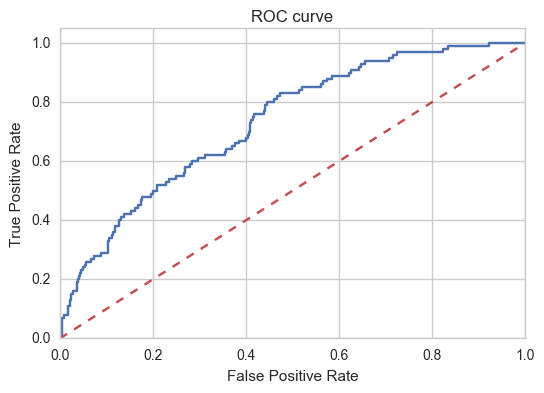

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='Logistic Regression')
plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.00])
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [15]:
AUC_log = metrics.roc_auc_score(y_test, probs_log[:, 1])
AUC_log

0.72294117647058831